In [17]:
%config IPCompleter.greedy=True

In [18]:
import sys
import os
import pandas as pd
sys.path.append("../..") # relative path to module toolkit

In [19]:
#from keras.applications import ResNet50
#from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras_preprocessing.image import ImageDataGenerator
from toolkit import getLabelsFromDir, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
# setup
batch_size = 1
val_dir = "../../../images/images_species/val/"
val_images = 3381
datasetDir = "images_species/"
saved_model = 'resNet50pretrained_highest_val_acc.h5'
results_file = "results.csv"

In [21]:
labels = getLabelsFromDir(val_dir)
val_datagen = ImageDataGenerator(rescale=1./255.)
validation_steps = int(val_images/batch_size) 

In [22]:
model = load_model(saved_model)

In [23]:
val_generator = val_datagen.flow_from_directory(val_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    shuffle=False,
                                                    seed=1)

Found 3381 images belonging to 200 classes.


In [24]:
Y_pred = model.predict_generator(val_generator, steps=validation_steps, verbose=1)

3381/3381 [==============================] - 91s 27ms/step


In [25]:
y_pred = np.argmax(Y_pred, axis=1)
y_pred3 = [y[-3:] for y in np.argsort(Y_pred, axis=1)] 

In [26]:
#print(classification_report(val_generator.classes, y_pred, target_names=labels))
print(classification_report(val_generator.classes, y_pred, target_names=labels))

                             precision    recall  f1-score   support

            Achenium humile       0.89      1.00      0.94         8
    Acylophorus glaberrimus       1.00      1.00      1.00        12
 Acylophorus wagenschieberi       1.00      1.00      1.00         8
           Astenus gracilis       0.59      0.53      0.56        19
       Astenus immacullatus       1.00      0.96      0.98        26
         Astenus lyonessius       0.73      0.63      0.68        30
           Astenus procerus       1.00      0.73      0.85        15
         Astenus pulchellus       0.69      1.00      0.82        25
            Atrecus affinis       0.90      1.00      0.95         9
          Atrecus longiceps       1.00      1.00      1.00         5
         Bisnius cephalotes       0.82      0.94      0.88        35
         Bisnius fimetarius       0.91      0.88      0.90        60
          Bisnius nitidulus       0.97      1.00      0.98        28
             Bisnius parcus      

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix, without normalization
[[ 8  0  0 ...,  0  0  0]
 [ 0 12  0 ...,  0  0  0]
 [ 0  0  8 ...,  0  0  0]
 ..., 
 [ 0  0  0 ...,  4  5  0]
 [ 0  0  0 ...,  1  9  0]
 [ 0  0  0 ...,  0  0 12]]


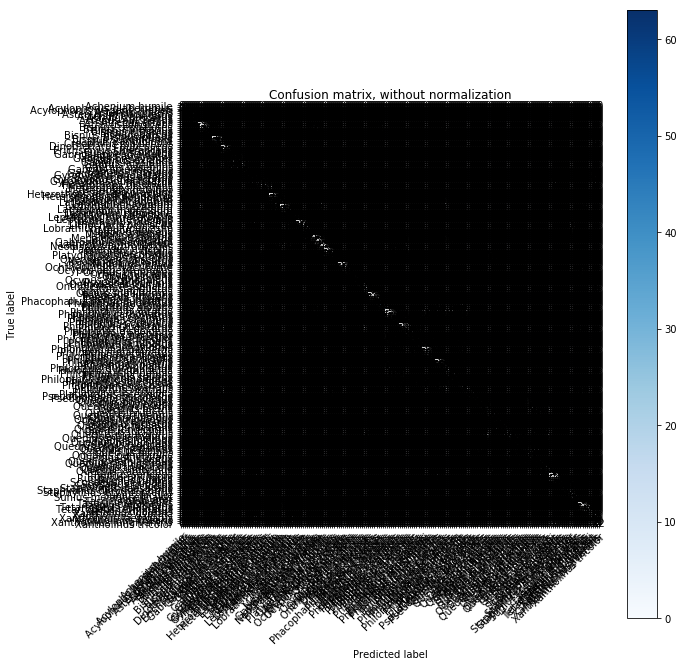

In [27]:
y_true = val_generator.classes
matplotlib.rcParams['figure.figsize'] = [10, 10]
plot_confusion_matrix(y_true, y_pred, np.array(labels))

In [28]:
labels = (val_generator.class_indices) # dict of label:index
labels = dict((i,l) for l,i in labels.items()) # dict of index:label

In [29]:
# create pd.dataframe and save predictions to .csv
filenames=[datasetDir + name for name in val_generator.filenames]
y_pred_labels = [labels[y] for y in y_pred]
y_true_labels = [labels[y] for y in y_true]
y_pred3_labels = []
for i,top3 in enumerate(y_pred3):
    l = []
    for top in top3:
        l.append((labels[top], Y_pred[i][top]))
    y_pred3_labels.append(l)

results=pd.DataFrame({"Filename":filenames,
                      "Label":y_true_labels,
                      "Prediction1":y_pred_labels,
                      "Prediction3":y_pred3_labels})
results.to_csv(results_file,index=True)